# Data Analysis
for model selection and results analysis 

## Libraries and imports

In [48]:
import sys
sys.path.append('..')
from scripts.utils import initialize_bucket, plot_importance

from datetime import date

import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold, cross_val_score,cross_validate
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, explained_variance_score,mean_absolute_percentage_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler, Normalizer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import shap

import pickle
import json

In [49]:
pd.set_option("display.max_columns", 400)

credentials_path = '../datascience-capstone-project-05b1642f45c3.json'

In [50]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

path = "gs://storage-barsianize/05_datasets/df_base_dataset.parquet"
df =  pd.read_parquet(path)

path = "gs://storage-barsianize/05_datasets/df_to_pred.parquet"
df_to_pred =  pd.read_parquet(path)

## Methods and functions

In [51]:
def load_model(path, model_name):
    """Load a trained model and associated preprocessing transformer.

    This function loads a trained machine learning model and identifies the appropriate
    estimator (LightGBM Regressor or XGBoost Regressor) from the pipeline steps. It also
    identifies any preprocessing transformers used in the pipeline.

    Args:
        path (str): The path to the directory containing the model file.
        model_name (str): The name of the model file.

    Returns:
        tuple: A tuple containing the loaded estimator and the preprocessing transformer.

    Raises:
        FileNotFoundError: If the specified model file does not exist.
    """
    with open(path + model_name, 'rb') as file:
        model = pickle.load(file)

    loaded_model = None
    for step_name, step_model in model.named_steps.items():
        if isinstance(step_model, LGBMRegressor):
            loaded_model = step_model
            break
        elif isinstance(step_model, XGBRegressor):
            loaded_model = step_model
            break
        elif step_name == 'preprocessing':
            transformer = step_model

    return loaded_model, transformer

In [52]:
def make_predictions(path, model_name, results_file, X_to_pred):
    """Make predictions using a trained model and return necessary components.

    This function loads a trained pipeline model and other relevant components,
    and then uses the model to predict target values for the provided data.

    Args:
        path (str): The path to the directory where the model and results file are located.
        model_name (str): The filename of the trained model in pickle format.
        results_file (str): The filename of the JSON results file containing features information.
        X_to_pred (pandas.DataFrame): The input data for which predictions need to be made.

    Returns:
        tuple: A tuple containing the following items:
            - predictions (numpy.ndarray): Predicted target values for the input data.
            - pipeline (sklearn.pipeline.Pipeline): The loaded pipeline model.
            - model: The trained machine learning model.
            - transformer: The data transformer used in the pipeline.
            - features (list): List of selected feature names used for predictions.

    Raises:
        FileNotFoundError: If the specified model file or results file does not exist.

    Example:
        # Assuming the trained model is saved as 'model.pkl' and results are in 'results.json'
        predictions, pipeline, model, transformer, features = make_predictions(
            'path/to/files/',
            'model.pkl',
            'results.json',
            X_test
        )
    """
    # model_name = '2023-08-04_LGBMRegressor_Normalizer()_feat_selection.pkl'
    with open(path + model_name, 'rb') as file:
        pipeline = pickle.load(file)

    with open(path + results_file, 'rb') as json_file:
        results = json.load(json_file)

    model, transformer = load_model(path, model_name)

    features = results['features']

    return pipeline.predict(X_to_pred[features]), pipeline, model, transformer, features

In [53]:
def get_feature_importances(model, model_class, features):
    """Get feature importances from a trained boosting model.

    This function calculates feature importances from a trained boosting model
    (LightGBM or XGBoost) based on their contribution to the model's predictions.

    Args:
        model (object): A trained boosting model object.
        model_class (str): A string indicating the class of the model (e.g., 'LGBM', 'XGB').
        features (list): A list of feature names used during training.

    Returns:
        pandas.DataFrame: A DataFrame containing feature importances sorted by total gain.

    Example:
        >>> import lightgbm as lgb
        >>> from xgboost import XGBRegressor
        >>> from sklearn.datasets import load_boston
        >>> boston = load_boston()
        >>> X, y, feature_names = boston.data, boston.target, boston.feature_names
        >>> lgb_model = lgb.LGBMRegressor().fit(X, y)
        >>> xgb_model = XGBRegressor().fit(X, y)
        >>> feature_importances_lgb = get_feature_importances(lgb_model, 'LGBM', feature_names)
        >>> feature_importances_xgb = get_feature_importances(xgb_model, 'XGB', feature_names)
    """    
    if 'LGB' in model_class:
        feature_importances = model.booster_.feature_importance(importance_type='gain')
    elif 'XGB' in model_class:
        feature_importances = model.get_booster().get_score(importance_type='gain').values()
        
    # Create a dictionary to associate feature names with their importance scores
    feature_importance_dict = dict(zip(features, feature_importances))
    df_feature_importance = pd.DataFrame(feature_importance_dict, 
                                      index=['Total gain']).T.sort_values(by='Total gain', ascending=False)
    return df_feature_importance

In [54]:
def calculate_shap_values(model, transformer, X_train, X_test, path, filename, plot=False):
    """
    Calculate SHAP (SHapley Additive exPlanations) values for a model's predictions.

    Args:
        model: A trained machine learning model.
        transformer: A data transformer or preprocessor used in the pipeline.
        X_train: The training data used for transformer fitting.
        X_test: The test data for which SHAP values will be calculated.
        path (str): The path to the directory where SHAP values will be saved.
        filename (str): The filename for saving the SHAP values.
        plot (bool, optional): If True, a summary plot of SHAP values will be generated.

    Returns:
        shap_values: The calculated SHAP values for the test data.
    """    
    # If the LightGBM model is found, convert it to a LightGBM Booster object and prepare the explainer
    if model is not None:
        # Assuming you have your test data in 'X_test' (replace 'X_test' with your actual test data)
        explainer = shap.Explainer(model, transformer.transform(X_train))

        # Calculate SHAP values for the test data
        shap_values = explainer(transformer.transform(X_test), check_additivity=False)

        # Save SHAP values to a file using pickle
        with open(path + filename, 'wb') as file:
            pickle.dump(shap_values, file)

        # plot shap summary if desired
        if plot:
            shap.summary_plot(shap_values, X_test)
        
        # Return SHAP values
        return shap_values
    
    else:
        print("LightGBM model not found in the pipeline.")
    

In [55]:
def get_dy_metrics(data, sort_col, filter_col,value_filter):
    """
    Calculate metrics related to 'dy_label', 'pl_mean_last', and 'cotacao_mean_last' based on different filters.

    Parameters:
    data (pd.DataFrame): Input DataFrame containing the data.
    sort_col (str): The column name to sort the data by.
    filter_col (str): The column name to filter the data by.
    value_filter: The value to filter the data on 'filter_col'.

    Returns:
    pd.DataFrame: A DataFrame containing calculated metrics based on different filters.
    """
    data = data.sort_values(by=sort_col, ascending=False)
    
    d = {}
    d['top5'] = {
                        'dy_mean'     : data['dy_label'].iloc[:5].mean(),
                        'pl_mean_last'     : data['pl_mean_last'].iloc[:5].mean(),
                        'cotacao_mean_last': data['cotacao_mean_last'].iloc[:5].mean()
                    }

    d['top10'] = {
                        'dy_mean'     : data['dy_label'].iloc[:10].mean(),
                        'pl_mean_last'     : data['pl_mean_last'].iloc[:10].mean(),
                        'cotacao_mean_last': data['cotacao_mean_last'].iloc[:10].mean()
                    }

    d['top20'] = {
                        'dy_mean'     : data['dy_label'].iloc[:20].mean(),
                        'pl_mean_last'     : data['pl_mean_last'].iloc[:20].mean(),
                        'cotacao_mean_last': data['cotacao_mean_last'].iloc[:20].mean()
                    }

    d[f'top5_{filter_col}'] = {
                        'dy_mean'     : data[data[filter_col]==value_filter]['dy_label'].iloc[:5].mean(),
                        'pl_mean_last'     : data[data[filter_col]==value_filter]['pl_mean_last'].iloc[:5].mean(),
                        'cotacao_mean_last': data[data[filter_col]==value_filter]['cotacao_mean_last'].iloc[:5].mean()
                    }

    d[f'top10_{filter_col}'] = {
                        'dy_mean'     : data[data[filter_col]==value_filter]['dy_label'].iloc[:10].mean(),
                        'pl_mean_last'     : data[data[filter_col]==value_filter]['pl_mean_last'].iloc[:10].mean(),
                        'cotacao_mean_last': data[data[filter_col]==value_filter]['cotacao_mean_last'].iloc[:10].mean()
                    }

    d[f'top20_{filter_col}'] = {
                        'dy_mean'     : data[data[filter_col]==value_filter]['dy_label'].iloc[:20].mean(),
                        'pl_mean_last'     : data[data[filter_col]==value_filter]['pl_mean_last'].iloc[:20].mean(),
                        'cotacao_mean_last': data[data[filter_col]==value_filter]['cotacao_mean_last'].iloc[:20].mean()
                    }

    return pd.DataFrame(d)

In [56]:
def plot_results(data, y, title, palette):
    """
    Plot the results using a bar plot.

    Parameters:
        data (pandas.DataFrame): The data containing results to be plotted.
        y (str): The name of the column containing the y-axis data.
        title (str): The title of the plot.
        palette (str or list of str): The color palette for the bars.

    Returns:
        None
    """    
    plt.figure(figsize=(20,20), dpi=400)
    ax = sns.barplot(x=data.sort_values(y).index,
                    y=y, palette=palette, data=data.sort_values(y))
    # ax = sns.barplot(x=df_grupos_de_despesas.index[:-1],
    #                  y='Valor', palette='viridis', data=df_grupos_de_despesas[:-1])
    plt.xlabel('Model Output',fontsize=24)
    plt.ylabel('DY [-]', fontsize=20)
    plt.title(title, fontsize=24)
    plt.xticks(rotation=90, fontsize=20)
    plt.yticks(fontsize=20)

    for p in ax.patches:
        ax.annotate('{:,.3f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.005), fontsize=20,rotation=0)
    sns.despine()
    plt.tight_layout()


def create_syled_sheet(data, filter_word_in, sort_col, cmap):
    return data.sort_values(sort_col, ascending=False)[[col for col in data.columns if filter_word_in in col]]\
        .style.background_gradient(cmap=cmap,axis=0)


## Analyse the prediction outcomes for each model
### Best models (Transformer + Algorithm + Feature Selection)

In [57]:
# separating the train and target features
X_to_pred = df_to_pred.drop(['year_month','Papel','Empresa','dy_label'], axis=1)
y_to_pred = df_to_pred['dy_label']

In [58]:
np.isin(['pl_mean_trend', 'pa_mean_trend', 'power_stabil'],df_to_pred.columns)

array([ True,  True,  True])

In [12]:
X_to_pred.columns

Index(['dy_median_max', 'dy_mean_last', 'dy_median_last', 'dy_spread',
       'power_min', 'dy_median_ref_min', 'dy_median_min', 'besst_1',
       'power_stabil_delta', 'Tipo_PN',
       ...
       'power_valuation', 'mrgliq_mean_last', 'mrgliq_mean_ref_mean',
       'roe_mean_ref_mean', 'psr_mean_ref_mean', 'roic_mean_ref_mean',
       'ibovespa_last', 'pib_dolarizado_last', 'igpm_last', 'ipca_last'],
      dtype='object', length=109)

100%|===================| 15181/15207 [06:20<00:00]        

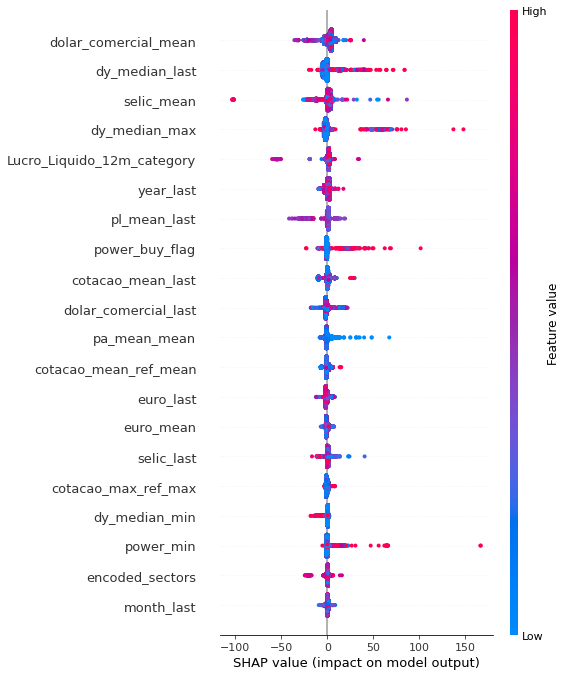

100%|===================| 15192/15207 [01:56<00:00]        

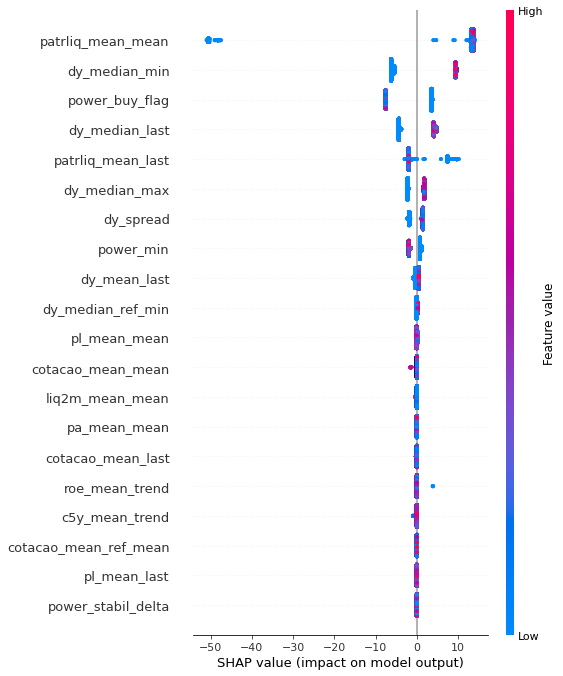

100%|===================| 15173/15207 [06:19<00:00]        

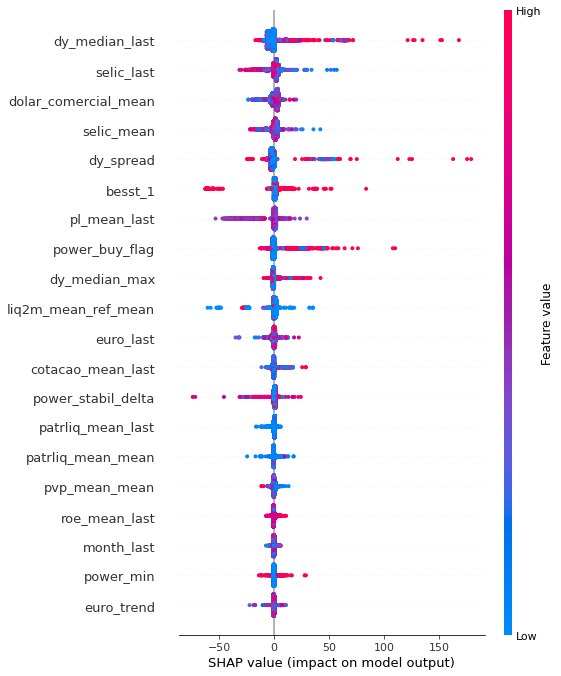

100%|===================| 15187/15207 [05:48<00:00]        

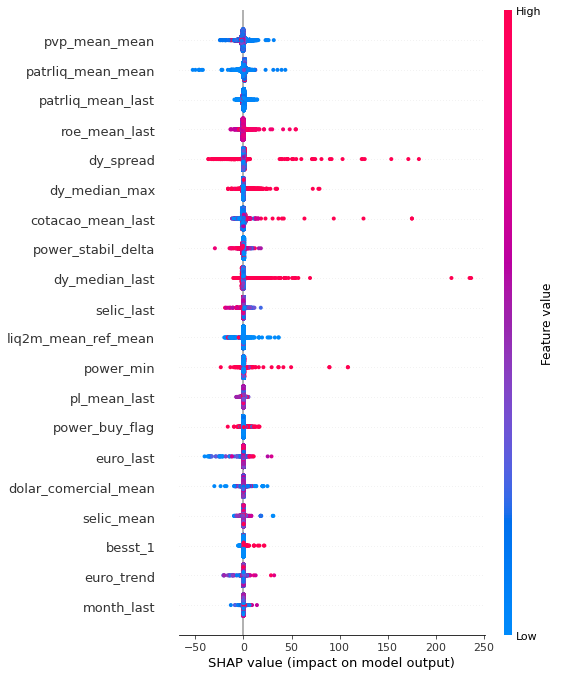

In [13]:
path = '../data/03_models/out/'

# '2023-08-27_LGBMRegressor_Normalizer()_feat_selection.pkl'

model_name = '2023-08-27_LGBMRegressor_Normalizer()_feat_selection.pkl'
results_file = '2023-08-27_LGBMRegressor_Normalizer()_results_feat_selection.json'
file_name_SHAP = '2023-08-27_LGBMRegressor_Normalizer()_results_feat_selection_SHAP.pkl'

df_to_pred['dy_pred_N_FS'], N_FS_0807_pipeline, N_FS_0807_model, N_FS_0807_transformer, N_FS_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[N_FS_0807_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

N_FS_0807_shap = calculate_shap_values(N_FS_0807_model, N_FS_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# '2023-08-27_LGBMRegressor_StandardScaler()_feat_selection.pkl' 

model_name = '2023-08-27_LGBMRegressor_StandardScaler()_feat_selection.pkl'
results_file = '2023-08-27_LGBMRegressor_StandardScaler()_results_feat_selection.json'
file_name_SHAP = '2023-08-27_LGBMRegressor_StandardScaler()_results_feat_selection_SHAP.pkl'

df_to_pred['dy_pred_S_FS'], S_FS_0807_pipeline, S_FS_0807_model, S_FS_0807_transformer, S_FS_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[S_FS_0807_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

S_FS_0807_shap = calculate_shap_values(S_FS_0807_model, N_FS_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



path = '../data/03_models/out/'

# '2023-08-05_LGBMRegressor_Normalizer()_feat_selection_lgbm.pkl'

model_name = '2023-08-27_LGBMRegressor_Normalizer()_feat_selection_lgbm.pkl'
results_file = '2023-08-27_LGBMRegressor_Normalizer()_results_feat_selection_lgbm.json'
file_name_SHAP = '2023-08-27_LGBMRegressor_Normalizer()_results_feat_selection_lgbm_SHAP.pkl'

df_to_pred['dy_pred_N_FS_LGBM'], N_FS_LGBM_0807_pipeline, N_FS_LGBM_0807_model, N_FS_LGBM_0807_transformer, N_FS_LGBM_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[N_FS_LGBM_0807_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

N_FS_LGBM_0807_shap = calculate_shap_values(N_FS_LGBM_0807_model, N_FS_LGBM_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# '2023-08-27_LGBMRegressor_StandardScaler()_feat_selection_lgbm.pkl' 

model_name = '2023-08-27_LGBMRegressor_StandardScaler()_feat_selection_lgbm.pkl'
results_file = '2023-08-27_LGBMRegressor_StandardScaler()_results_feat_selection_lgbm.json'
file_name_SHAP = '2023-08-27_LGBMRegressor_StandardScaler()_results_feat_selection_lgbm_SHAP.pkl'

df_to_pred['dy_pred_S_FS_LGBM'], S_FS_LGBM_0807_pipeline, S_FS_LGBM_0807_model, S_FS_LGBM_0807_transformer, S_FS_LGBM_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[S_FS_LGBM_0807_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

S_FS_LGBM_0807_shap = calculate_shap_values(S_FS_LGBM_0807_model, S_FS_LGBM_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)

 99%|===================| 15106/15207 [00:59<00:00]        

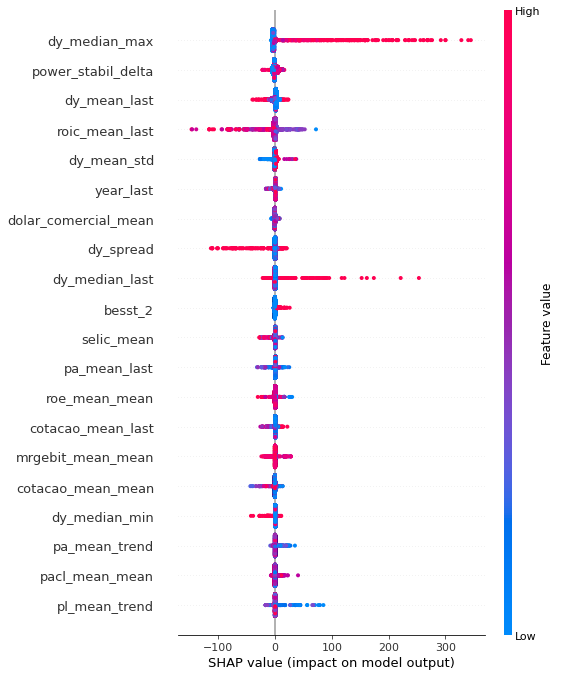

 99%|===================| 15020/15207 [00:59<00:00]        

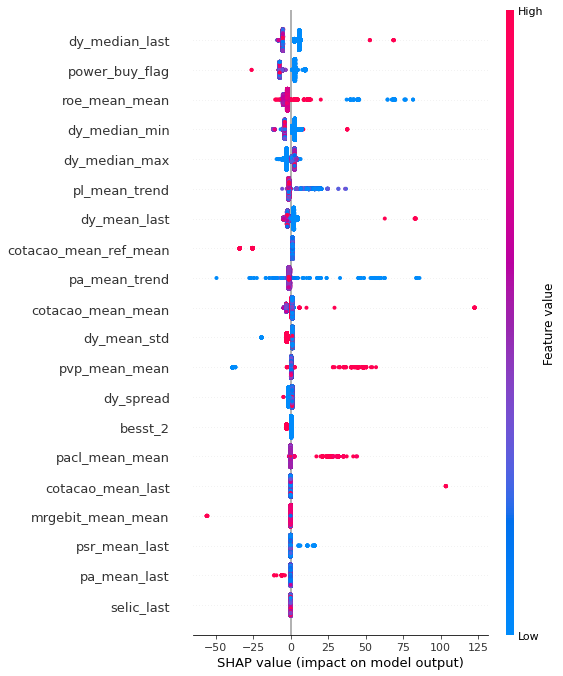

 99%|===================| 15125/15207 [02:30<00:00]        

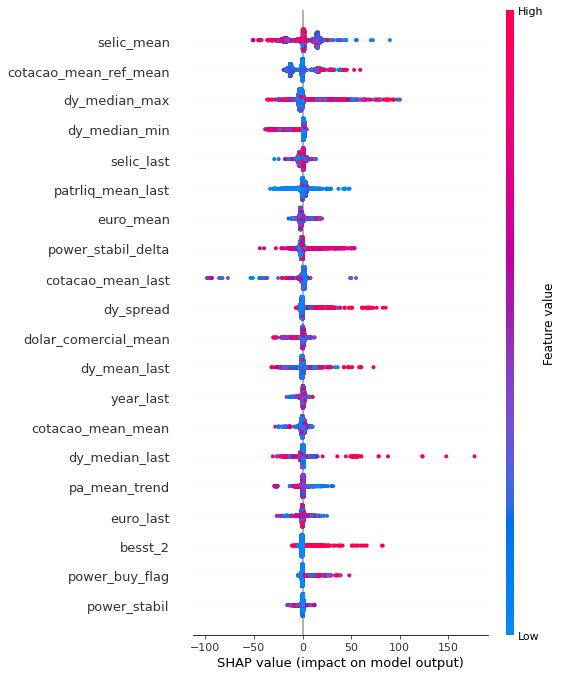

 99%|===================| 15114/15207 [01:39<00:00]        

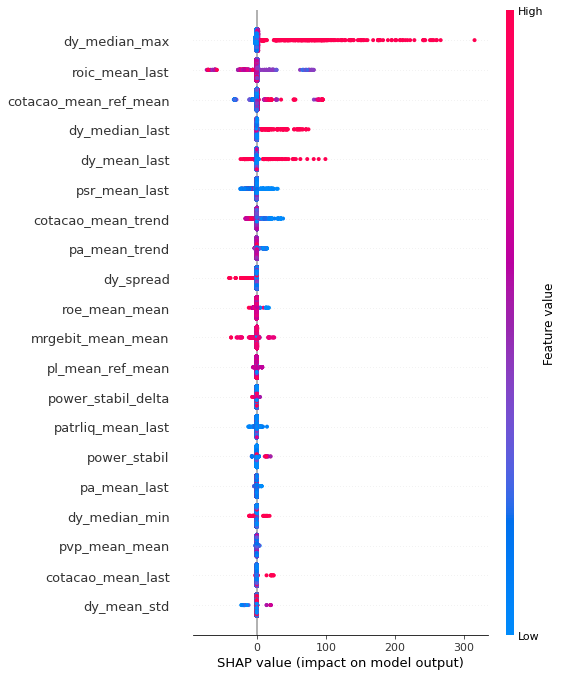

In [14]:
path = '../data/03_models/out/'

# '2023-08-08_LGBMRegressor_Normalizer()_feat_selection.pkl'

model_name = '2023-08-08_LGBMRegressor_Normalizer()_feat_selection.pkl'
results_file = '2023-08-08_LGBMRegressor_Normalizer()_results_feat_selection.json'
file_name_SHAP = '2023-08-08_LGBMRegressor_Normalizer()_results_feat_selection_SHAP.pkl'

df_to_pred['dy_pred_N_FS_0808'], N_FS_0808_pipeline, N_FS_0808_model, N_FS_0808_transformer, N_FS_0808_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[N_FS_0808_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

N_FS_0808_shap = calculate_shap_values(N_FS_0808_model, N_FS_0808_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# '2023-08-08_LGBMRegressor_StandardScaler()_feat_selection.pkl' 

model_name = '2023-08-08_LGBMRegressor_StandardScaler()_feat_selection.pkl'
results_file = '2023-08-08_LGBMRegressor_StandardScaler()_results_feat_selection.json'
file_name_SHAP = '2023-08-08_LGBMRegressor_StandardScaler()_results_feat_selection_SHAP.pkl'

df_to_pred['dy_pred_S_FS_0808'], S_FS_0808_pipeline, S_FS_0808_model, S_FS_0808_transformer, S_FS_0808_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[S_FS_0808_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

S_FS_0808_shap = calculate_shap_values(S_FS_0808_model, N_FS_0808_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



path = '../data/03_models/out/'

# '2023-08-05_LGBMRegressor_Normalizer()_feat_selection_lgbm.pkl'

model_name = '2023-08-08_LGBMRegressor_Normalizer()_feat_selection_lgbm.pkl'
results_file = '2023-08-08_LGBMRegressor_Normalizer()_results_feat_selection_lgbm.json'
file_name_SHAP = '2023-08-08_LGBMRegressor_Normalizer()_results_feat_selection_lgbm_SHAP.pkl'

df_to_pred['dy_pred_N_FS_LGBM_0808'], N_FS_LGBM_0808_pipeline, N_FS_LGBM_0808_model, N_FS_LGBM_0808_transformer, N_FS_LGBM_0808_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[N_FS_LGBM_0808_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

N_FS_LGBM_0808_shap = calculate_shap_values(N_FS_LGBM_0808_model, N_FS_LGBM_0808_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# '2023-08-08_LGBMRegressor_StandardScaler()_feat_selection_lgbm.pkl' 

model_name = '2023-08-08_LGBMRegressor_StandardScaler()_feat_selection_lgbm.pkl'
results_file = '2023-08-08_LGBMRegressor_StandardScaler()_results_feat_selection_lgbm.json'
file_name_SHAP = '2023-08-08_LGBMRegressor_StandardScaler()_results_feat_selection_lgbm_SHAP.pkl'

df_to_pred['dy_pred_S_FS_LGBM_0808'], S_FS_LGBM_0808_pipeline, S_FS_LGBM_0808_model, S_FS_LGBM_0808_transformer, S_FS_LGBM_0808_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[S_FS_LGBM_0808_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

S_FS_LGBM_0808_shap = calculate_shap_values(S_FS_LGBM_0808_model, S_FS_LGBM_0808_transformer, X_train, X_test, path, file_name_SHAP, plot=True)


## Recommend 20 best Stocks

In [59]:
df_to_pred['Papel_root'] = df_to_pred['Papel'].str[:4]

df_recommend = df_to_pred[['Empresa','Papel','Papel_root','besst_1','besst_2','dy_label','pl_mean_last','cotacao_mean_last',
                            'dy_pred_N_FS',
                            'dy_pred_S_FS',
                            'dy_pred_N_FS_LGBM',
                            'dy_pred_S_FS_LGBM',
                            'dy_pred_N_FS_0808',
                            'dy_pred_S_FS_0808',
                            'dy_pred_N_FS_LGBM_0808',
                            'dy_pred_S_FS_LGBM_0808']]\
                    .sort_values(by='dy_pred_N_FS', ascending=False)\
                    .drop_duplicates(subset=['Papel_root'], keep='first')

KeyError: "['dy_pred_N_FS', 'dy_pred_S_FS', 'dy_pred_N_FS_LGBM', 'dy_pred_S_FS_LGBM', 'dy_pred_N_FS_0808', 'dy_pred_S_FS_0808', 'dy_pred_N_FS_LGBM_0808', 'dy_pred_S_FS_LGBM_0808'] not in index"

In [47]:
df_recomment = df_recommend[df_recommend['dy_label']<1]

In [ ]:
df_recommend.sort_values(by='dy_pred_N_FS_LGBM', ascending=False).iloc[:30]

Empresa  Papel Papel_root  besst_1  \
10352                              BANPARÁ S.A. ON  BPAR3       BPAR      1.0   
17145                                     CELPE ON  CEPE3       CEPE      1.0   
8344              BANCO MERCANTIL DO BRASIL S/A PN  BMEB4       BMEB      1.0   
35781                              AES TIETE SA PN  GETI4       GETI      1.0   
56615                            CELULOSE IRANI PN  RANI4       RANI      0.0   
10655                          BRADESPAR S/A ON N1  BRAP3       BRAP      0.0   
30959                                  ENERGISA PN  ENGI4       ENGI      1.0   
38115                                    Helbor ON  HBOR3       HBOR      0.0   
9004                                     MONARK ON  BMKS3       BMKS      0.0   
83408                                 CELESC PN N2  CLSC4       CLSC      1.0   
68854                                     TEKNO PN  TKNO4       TKNO      0.0   
75323                            WHIRLPOOL S.A. PN  WHRL4       WHRL      0.0   
45611                  TREVISA INVESTIMENTOS SA ON  LUXM3       LUXM      0.0   
18520  COMPANHIA DE GÁS DE SÃO PAULO - COMGÁS PNAS  CGAS5       CGAS      0.0   
78829                                 FLEURY ON NM  FLRY3       FLRY      0.0   
37753                     GUARARAPES CONFECÇÕES PN  GUAR4       GUAR      0.0   
1563                              BRASILAGRO ON NM  AGRO3       AGRO      0.0   
79866                          BR PROPERTIES ON NM  BRPR3       BRPR      0.0   
3114                               AMPLA INVEST ON  AMPI3       AMPI      1.0   
68765                                  Tegma ON NM  TGMA3       TGMA      0.0   
45455                               LUPATECH ON NM  LUPA3       LUPA      0.0   
69506                                 Trisul ON NM  TRIS3       TRIS      0.0   
64962       SANSUY S.A. INDÚSTRIA DE PLÁSTICOS PNA  SNSY5       SNSY      0.0   
51551                              PANATLANTICA PN  PATI4       PATI      0.0   
28070      ELEKTRO ELETRICIDADE E SERVIÇOS S.A. ON  EKTR3       EKTR      1.0   
88799                                 SMILES ON NM  SMLS3       SMLS      0.0   
38273                            CIA HABITASUL PNA  HBTS5       HBTS      0.0   
84746                           BBSEGURIDADE ON NM  BBSE3       BBSE      1.0   
64441                           EDITORA SARAIVA ON  SLED3       SLED      0.0   
15986   CEB - COMPANHIA ENERGÉTICA DE BRASÍLIA PNA  CEBR5       CEBR      1.0   

       besst_2  dy_label  pl_mean_last  cotacao_mean_last  dy_pred_N_FS  \
10352      0.0  633.1490      5.320000         182.070000    633.060264   
17145      0.0  159.0300      4.290000          27.000000    158.829503   
8344       0.0    0.0736      3.110000           4.950000    105.398101   
35781      0.0    0.0905      7.840000          20.200000     94.076427   
56615      1.0   81.3460      5.450000           1.550000     81.982593   
10655      1.0    0.0677     32.790000           9.520000     61.996361   
30959      0.0    0.0386      7.410000           1.940000     37.475009   
38115      0.0    0.0360      7.926667           8.503333     21.344436   
9004       0.0    0.0509      0.820000         338.000000     40.467587   
83408      0.0    0.0152      0.775000          10.280000     51.282624   
68854      1.0   32.7337      9.340000          93.000000     30.212634   
75323      0.0    0.0579      7.665000           4.025000     42.749056   
45611      0.0   28.9311    -47.250000          40.500000     38.058305   
18520      0.0    0.0596     17.273333         178.226667     23.707153   
78829      0.0    0.0121     38.817500          14.877500      4.694979   
37753      0.0   16.3057     17.005000          95.375000     12.556325   
1563       0.0    0.0476     11.777500          13.450000      3.623890   
79866      0.0    0.5067     -7.190000          12.010000     69.726783   
3114       0.0   15.4809     12.410000          55.000000      8.394775   
68765      0.0    0.0465     16

In [17]:
dict_results = {'dy_pred_N_FS_0808'      :get_dy_metrics(df_recommend, 'dy_pred_N_FS_0808', 'besst_1', 1),
                'dy_pred_S_FS_0808'      :get_dy_metrics(df_recommend, 'dy_pred_S_FS_0808', 'besst_1', 1),
                'dy_pred_N_FS_LGBM_0808' :get_dy_metrics(df_recommend, 'dy_pred_N_FS_LGBM_0808', 'besst_1', 1),
                'dy_pred_S_FS_LGBM_0808' :get_dy_metrics(df_recommend, 'dy_pred_S_FS_LGBM_0808', 'besst_1', 1),
                'dy_pred_N_FS'      :get_dy_metrics(df_recommend, 'dy_pred_N_FS', 'besst_1', 1),
                'dy_pred_S_FS'      :get_dy_metrics(df_recommend, 'dy_pred_S_FS', 'besst_1', 1),
                'dy_pred_N_FS_LGBM' :get_dy_metrics(df_recommend, 'dy_pred_N_FS_LGBM', 'besst_1', 1),
                'dy_pred_S_FS_LGBM' :get_dy_metrics(df_recommend, 'dy_pred_S_FS_LGBM', 'besst_1', 1)}

dict_results2= {'dy_pred_N_FS_0808'      :get_dy_metrics(df_recommend, 'dy_pred_N_FS_0808', 'besst_2', 1),
                'dy_pred_S_FS_0808'      :get_dy_metrics(df_recommend, 'dy_pred_S_FS_0808', 'besst_2', 1),
                'dy_pred_N_FS_LGBM_0808' :get_dy_metrics(df_recommend, 'dy_pred_N_FS_LGBM_0808', 'besst_2', 1),
                'dy_pred_S_FS_LGBM_0808' :get_dy_metrics(df_recommend, 'dy_pred_S_FS_LGBM_0808', 'besst_2', 1),
                'dy_pred_N_FS'      :get_dy_metrics(df_recommend, 'dy_pred_N_FS', 'besst_2', 1),
                'dy_pred_S_FS'      :get_dy_metrics(df_recommend, 'dy_pred_S_FS', 'besst_2', 1),
                'dy_pred_N_FS_LGBM' :get_dy_metrics(df_recommend, 'dy_pred_N_FS_LGBM', 'besst_2', 1),
                'dy_pred_S_FS_LGBM' :get_dy_metrics(df_recommend, 'dy_pred_S_FS_LGBM', 'besst_2', 1)}

                

In [18]:
df_recommend['score'] = np.log(1 + df_recommend['dy_pred_N_FS_0808'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_N_FS_0808']['top10'].loc['dy_mean']) + \
                        np.log(1 + df_recommend['dy_pred_S_FS_0808'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_S_FS_0808']['top10'].loc['dy_mean']) + \
                        np.log(1 + df_recommend['dy_pred_N_FS_LGBM_0808'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_N_FS_LGBM_0808']['top10'].loc['dy_mean']) + \
                        np.log(1 + df_recommend['dy_pred_S_FS_LGBM_0808'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_S_FS_LGBM_0808']['top10'].loc['dy_mean']) + \
                        np.log(1 + df_recommend['dy_pred_N_FS'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_N_FS']['top10'].loc['dy_mean']) + \
                        np.log(1 + df_recommend['dy_pred_S_FS'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_S_FS']['top10'].loc['dy_mean']) + \
                        np.log(1 + df_recommend['dy_pred_N_FS_LGBM'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_N_FS_LGBM']['top10'].loc['dy_mean']) + \
                        np.log(1 + df_recommend['dy_pred_S_FS_LGBM'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_S_FS_LGBM']['top10'].loc['dy_mean'])

In [19]:
dict_results['score'] = get_dy_metrics(df_recommend, 'score', 'besst_1', 1)
dict_results2['score'] = get_dy_metrics(df_recommend, 'score', 'besst_2', 1)

In [20]:
top_results = {}
for key in dict_results.keys():
    top_results[key] = df_recommend.sort_values(by=key, ascending=False)['dy_label'].iloc[:50].to_list()

for key in dict_results.keys():
    top_results[f'{key}_besst_1'] = df_recommend[df_recommend['besst_1']==1].sort_values(by=key, ascending=False)['dy_label'].iloc[:50].to_list()

for key in dict_results.keys():
    top_results[f'{key}_besst_2'] = df_recommend[df_recommend['besst_2']==1].sort_values(by=key, ascending=False)['dy_label'].iloc[:50].to_list()

df_top_results = pd.DataFrame(top_results)

In [21]:
df_top_results_melt_top20 = pd.melt(df_top_results.iloc[:20][df_top_results.columns], 
                                value_name='DY_mean_top20', var_name='Model').groupby('Model').mean()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[:10][df_top_results.columns], 
                                value_name='DY_mean_top10', var_name='Model').groupby('Model').mean()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[:5][df_top_results.columns], 
                                value_name='DY_mean_top5', var_name='Model').groupby('Model').mean()               




df_top_results_melt_full = pd.concat([df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

df_top_results_melt_top20 = pd.melt(df_top_results.iloc[:20][df_top_results.columns], 
                                value_name='DY_std_top20', var_name='Model').groupby('Model').std()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[:10][df_top_results.columns], 
                                value_name='DY_std_top10', var_name='Model').groupby('Model').std()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[:5][df_top_results.columns], 
                                value_name='DY_std_top5', var_name='Model').groupby('Model').std()  

df_top_results_melt_full = pd.concat([df_top_results_melt_full,df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

df_top_results_melt_top20 = pd.melt(df_top_results.iloc[:20][df_top_results.columns], 
                                value_name='DY_median_top20', var_name='Model').groupby('Model').median()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[:10][df_top_results.columns], 
                                value_name='DY_median_top10', var_name='Model').groupby('Model').median()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[:5][df_top_results.columns], 
                                value_name='DY_median_top5', var_name='Model').groupby('Model').median()  

df_top_results_melt_full = pd.concat([df_top_results_melt_full,df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

df_top_results_melt_full.head()

DY_mean_top5  DY_mean_top10  DY_mean_top20  \
Model                                                                   
dy_pred_N_FS                  158.47670       87.43770      46.829915   
dy_pred_N_FS_0808             126.70288       63.91557      36.042715   
dy_pred_N_FS_0808_besst_1     126.67116       63.36619      31.712430   
dy_pred_N_FS_0808_besst_2      22.81900       11.47325       5.757445   
dy_pred_N_FS_LGBM             174.73782       87.38975      48.403965   

                           DY_std_top5  DY_std_top10  DY_std_top20  \
Model                                                                
dy_pred_N_FS                274.132217    198.978540    143.423074   
dy_pred_N_FS_0808           283.112018    200.015362    141.708183   
dy_pred_N_FS_0808_besst_1   283.129724    200.201280    141.563486   
dy_pred_N_FS_0808_besst_2    35.655060     26.609358     19.229852   
dy_pred_N_FS_LGBM           264.631278    199.001873    142.964998   

                           DY_median_top5  DY_median_top10  DY_median_top20  
Model                                                                        
dy_pred_N_FS                       0.0905          0.08205          0.07065  
dy_pred_N_FS_0808                  0.0509          0.07115          0.05185  
dy_pred_N_FS_0808_besst_1          0.0914          0.07045          0.06495  
dy_pred_N_FS_0808_besst_2          0.0153          0.04745          0.02245  
dy_pred_N_FS_LGBM                 81.3460          0.07065          0.07065

### Analysis for the overall stocks

In [22]:
df_top_results_melt = df_top_results_melt_full.loc[[index for index in df_top_results_melt_full.index if 'besst_' not in index]]

df_top_results_melt[['DY_sharpe_ratio_top5','DY_sharpe_ratio_top10','DY_sharpe_ratio_top20']] = \
        np.divide(df_top_results_melt[[col for col in df_top_results_melt.columns if 'mean' in col]].values, 
                  df_top_results_melt[[col for col in df_top_results_melt.columns if 'std' in col]].values)

df_top_results_melt

DY_mean_top5  DY_mean_top10  DY_mean_top20  \
Model                                                                
dy_pred_N_FS               158.47670       87.43770      46.829915   
dy_pred_N_FS_0808          126.70288       63.91557      36.042715   
dy_pred_N_FS_LGBM          174.73782       87.38975      48.403965   
dy_pred_N_FS_LGBM_0808     126.65044       63.34247      43.704915   
dy_pred_S_FS               181.35308       93.57474      47.914125   
dy_pred_S_FS_0808          126.72254       63.37571      31.987090   
dy_pred_S_FS_LGBM          187.03796       95.17842      48.657010   
dy_pred_S_FS_LGBM_0808     126.70580       63.91074      31.981105   
score                      174.71624       91.19875      46.447400   

                        DY_std_top5  DY_std_top10  DY_std_top20  \
Model                                                             
dy_pred_N_FS             274.132217    198.978540    143.423074   
dy_pred_N_FS_0808        283.112018    200.015362    141.708183   
dy_pred_N_FS_LGBM        264.631278    199.001873    142.964998   
dy_pred_N_FS_LGBM_0808   283.141306    200.209611    144.109428   
dy_pred_S_FS             259.524769    196.392977    143.099961   
dy_pred_S_FS_0808        283.101022    200.197948    141.503929   
dy_pred_S_FS_LGBM        254.842049    195.610285    142.879945   
dy_pred_S_FS_LGBM_0808   283.110384    200.017074    141.505349   
score                    264.649083    197.403787    143.454595   

                        DY_median_top5  DY_median_top10  DY_median_top20  \
Model                                                                      
dy_pred_N_FS                    0.0905          0.08205          0.07065   
dy_pred_N_FS_0808               0.0509          0.07115          0.05185   
dy_pred_N_FS_LGBM              81.3460          0.07065          0.07065   
dy_pred_N_FS_LGBM_0808          0.0053          0.01730          0.03395   
dy_pred_S_FS                   81.3460         14.71890          0.11560   
dy_pred_S_FS_0808               0.0837          0.05645          0.05995   
dy_pred_S_FS_LGBM              81.3460         22.61840          0.09050   
dy_pred_S_FS_LGBM_0808          0.0509          0.05645          0.05995   
score                          81.3460          2.76565          0.08205   

                        DY_sharpe_ratio_top5  DY_sharpe_ratio_top10  \
Model                                                                 
dy_pred_N_FS                        0.578103               0.439433   
dy_pred_N_FS_0808                   0.447536               0.319553   
dy_pred_N_FS_LGBM                   0.660307               0.439140   
dy_pred_N_FS_LGBM_0808              0.447305               0.316381   
dy_pred_S_FS                        0.698789               0.476467   
dy_pred_S_FS_0808                   0.447623               0.316565   
dy_pred_S_FS_LGBM                   0.733937               0.486572   
dy_pred_S_FS_LGBM_0808              0.447549               0.319526   
score                               0.660181               0.461991   

                        DY_sharpe_ratio_top20  
Model                                          
dy_pred_N_FS                         0.326516  
dy_pred_N_FS_0808                    0.254345  
dy_pred_N_FS_LGBM                    0.338572  
dy_pred_N_FS_LGBM_0808               0.303276  
dy_pred_S_FS                         0.334830  
dy_pred_S_FS_0808                    0.226051  
dy_pred_S_FS_LGBM                    0.340545  
dy_pred_S_FS_LGBM_0808               0.226006  
score                                0.323778

#### Top 5 Stocks

In [23]:
plot_results(df_top_results_melt, 'DY_mean_top5', 'DY Mean Value - Top 5','rocket')

In [24]:
plot_results(df_top_results_melt, 'DY_std_top5', 'DY Std Value - Top 5','viridis')

In [25]:
plot_results(df_top_results_melt, 'DY_mean_top10', 'DY Std Value - Top 10','rocket')

#### Top 10 Stocks

In [26]:
plot_results(df_top_results_melt, 'DY_mean_top10', 'DY Std Value - Top 10','rocket')

In [27]:
plot_results(df_top_results_melt, 'DY_std_top10', 'DY Std Value - Top 10','viridis')

#### Top 20 Stocks

In [28]:
plot_results(df_top_results_melt, 'DY_mean_top20', 'DY Mean Value - Top 20','rocket')

In [29]:
plot_results(df_top_results_melt, 'DY_std_top20', 'DY Std Value - Top 20','viridis')

#### Overall results

In [30]:
create_syled_sheet(df_top_results_melt, 'mean', 'DY_mean_top10', 'vlag')

In [31]:
create_syled_sheet(df_top_results_melt, 'sharpe_ratio', 'DY_sharpe_ratio_top10', 'vlag')

### Analysis for the BESST_1 Stocks (Sectors: A, B C ...)

In [32]:
df_top_results_melt = df_top_results_melt_full.loc[[index for index in df_top_results_melt_full.index if 'besst_1' in index]]

df_top_results_melt[['DY_sharpe_ratio_top5','DY_sharpe_ratio_top10','DY_sharpe_ratio_top20']] = \
        np.divide(df_top_results_melt[[col for col in df_top_results_melt.columns if 'mean' in col]].values, 
                  df_top_results_melt[[col for col in df_top_results_melt.columns if 'std' in col]].values)

df_top_results_melt

DY_mean_top5  DY_mean_top10  DY_mean_top20  \
Model                                                                        
dy_pred_N_FS_0808_besst_1          126.67116       63.36619      31.712430   
dy_pred_N_FS_LGBM_0808_besst_1     126.65816       79.26183      39.651775   
dy_pred_N_FS_LGBM_besst_1          158.47634       80.80411      40.433945   
dy_pred_N_FS_besst_1               158.47670       79.26322      40.440820   
dy_pred_S_FS_0808_besst_1          126.67072       79.27204      39.664710   
dy_pred_S_FS_LGBM_0808_besst_1     126.66126       79.25851      39.658050   
dy_pred_S_FS_LGBM_besst_1          161.55524       80.80421      40.423690   
dy_pred_S_FS_besst_1               158.48812       79.29276      40.443495   
score_besst_1                      158.47104       79.26065      40.438545   

                                DY_std_top5  DY_std_top10  DY_std_top20  \
Model                                                                     
dy_pred_N_FS_0808_besst_1        283.129724    200.201280    141.563486   
dy_pred_N_FS_LGBM_0808_besst_1   283.136990    200.926703    144.134990   
dy_pred_N_FS_LGBM_besst_1        274.132477    200.309439    143.949896   
dy_pred_N_FS_besst_1             274.132217    200.926092    143.947866   
dy_pred_S_FS_0808_besst_1        283.129969    200.922229    144.131247   
dy_pred_S_FS_LGBM_0808_besst_1   283.135256    200.928155    144.133173   
dy_pred_S_FS_LGBM_besst_1        271.986849    200.309395    143.952920   
dy_pred_S_FS_besst_1             274.123970    200.913161    143.947079   
score_besst_1                    274.136307    200.927219    143.948537   

                                DY_median_top5  DY_median_top10  \
Model                                                             
dy_pred_N_FS_0808_besst_1               0.0914          0.07045   
dy_pred_N_FS_LGBM_0808_besst_1          0.0386          0.06925   
dy_pred_N_FS_LGBM_besst_1               0.0905          0.08205   
dy_pred_N_FS_besst_1                    0.0905          0.06925   
dy_pred_S_FS_0808_besst_1               0.0777          0.08455   
dy_pred_S_FS_LGBM_0808_besst_1          0.0632          0.06840   
dy_pred_S_FS_LGBM_besst_1              15.4809          0.08750   
dy_pred_S_FS_besst_1                    0.1339          0.10185   
score_besst_1                           0.0973          0.08205   

                                DY_median_top20  DY_sharpe_ratio_top5  \
Model                                                                   
dy_pred_N_FS_0808_besst_1               0.06495              0.447396   
dy_pred_N_FS_LGBM_0808_besst_1          0.05060              0.447339   
dy_pred_N_FS_LGBM_besst_1               0.07565              0.578101   
dy_pred_N_FS_besst_1                    0.08885              0.578103   
dy_pred_S_FS_0808_besst_1               0.07610              0.447394   
dy_pred_S_FS_LGBM_0808_besst_1          0.06840              0.447352   
dy_pred_S_FS_LGBM_besst_1               0.06005              0.593982   
dy_pred_S_FS_besst_1                    0.07910              0.578162   
score_besst_1                           0.07650              0.578074   

                                DY_sharpe_ratio_top10  DY_sharpe_ratio_top20  
Model                                                                         
dy_pred_N_FS_0808_besst_1                    0.316512               0.224016  
dy_pred_N_FS_LGBM_0808_besst_1               0.394481               0.275102  
dy_pred_N_FS_LGBM_besst_1                    0.403396               0.280889  
dy_pred_N_FS_besst_1                         0.394489               0.280941  
dy_pred_S_FS_0808_besst_1                    0.394541               0.275199  
dy_pred_S_FS_LGBM_0808_besst_1               0.394462               0.275149  
dy_pred_S_FS_LGBM_besst_1                    0.403397               0.280812  
dy_pred_S_FS_besst_1                         0.394662               0.280961  
score_besst_1  

In [33]:
create_syled_sheet(df_top_results_melt, 'mean', 'DY_mean_top10', 'vlag')

In [34]:
create_syled_sheet(df_top_results_melt, 'sharpe_ratio', 'DY_sharpe_ratio_top10', 'vlag')

### Analysis for the BESST_2 Stocks (Sectors: A, B C ...)

In [35]:
df_top_results_melt = df_top_results_melt_full.loc[[index for index in df_top_results_melt_full.index if 'besst_2' in index]]

df_top_results_melt[['DY_sharpe_ratio_top5','DY_sharpe_ratio_top10','DY_sharpe_ratio_top20']] = \
        np.divide(df_top_results_melt[[col for col in df_top_results_melt.columns if 'mean' in col]].values, 
                  df_top_results_melt[[col for col in df_top_results_melt.columns if 'std' in col]].values)

df_top_results_melt

DY_mean_top5  DY_mean_top10  DY_mean_top20  \
Model                                                                        
dy_pred_N_FS_0808_besst_2           22.81900       11.47325       5.757445   
dy_pred_N_FS_LGBM_0808_besst_2      16.31340        8.15683       4.088125   
dy_pred_N_FS_LGBM_besst_2           22.84202       11.47252       5.753650   
dy_pred_N_FS_besst_2                22.84834       11.47946       5.753655   
dy_pred_S_FS_0808_besst_2           16.29198        8.21047       5.750875   
dy_pred_S_FS_LGBM_0808_besst_2      16.37502        8.20739       5.761355   
dy_pred_S_FS_LGBM_besst_2           22.86168       11.44395       5.730335   
dy_pred_S_FS_besst_2                22.82390       11.46614       5.736135   
score_besst_2                       22.83452       11.46470       5.750155   

                                DY_std_top5  DY_std_top10  DY_std_top20  \
Model                                                                     
dy_pred_N_FS_0808_besst_2         35.655060     26.609358     19.229852   
dy_pred_N_FS_LGBM_0808_besst_2    36.354343     25.716077     18.184641   
dy_pred_N_FS_LGBM_besst_2         35.636659     26.609696     19.231020   
dy_pred_N_FS_besst_2              35.631612     26.606387     19.231038   
dy_pred_S_FS_0808_besst_2         36.366310     25.697526     19.231880   
dy_pred_S_FS_LGBM_0808_besst_2    36.320321     25.698613     19.228601   
dy_pred_S_FS_LGBM_besst_2         35.620973     26.623021     19.238092   
dy_pred_S_FS_besst_2              35.651144     26.612742     19.236482   
score_besst_2                     35.642655     26.613430     19.232109   

                                DY_median_top5  DY_median_top10  \
Model                                                             
dy_pred_N_FS_0808_besst_2               0.0153          0.04745   
dy_pred_N_FS_LGBM_0808_besst_2          0.0677          0.01260   
dy_pred_N_FS_LGBM_besst_2               0.0677          0.04910   
dy_pred_N_FS_besst_2                    0.0943          0.06520   
dy_pred_S_FS_0808_besst_2               0.0239          0.04910   
dy_pred_S_FS_LGBM_0808_besst_2          0.0677          0.03370   
dy_pred_S_FS_LGBM_besst_2               0.1597          0.05225   
dy_pred_S_FS_besst_2                    0.0398          0.03285   
score_besst_2                           0.0677          0.02490   

                                DY_median_top20  DY_sharpe_ratio_top5  \
Model                                                                   
dy_pred_N_FS_0808_besst_2               0.02245              0.639993   
dy_pred_N_FS_LGBM_0808_besst_2          0.00915              0.448733   
dy_pred_N_FS_LGBM_besst_2               0.02890              0.640970   
dy_pred_N_FS_besst_2                    0.01960              0.641238   
dy_pred_S_FS_0808_besst_2               0.02490              0.447997   
dy_pred_S_FS_LGBM_0808_besst_2          0.03765              0.450850   
dy_pred_S_FS_LGBM_besst_2               0.01695              0.641804   
dy_pred_S_FS_besst_2                    0.00705              0.640201   
score_besst_2                           0.02490              0.640651   

                                DY_sharpe_ratio_top10  DY_sharpe_ratio_top20  
Model                                                                         
dy_pred_N_FS_0808_besst_2                    0.431173               0.299401  
dy_pred_N_FS_LGBM_0808_besst_2               0.317188               0.224812  
dy_pred_N_FS_LGBM_besst_2                    0.431141               0.299186  
dy_pred_N_FS_besst_2                         0.431455               0.299186  
dy_pred_S_FS_0808_besst_2                    0.319504               0.299028  
dy_pred_S_FS_LGBM_0808_besst_2               0.319371               0.299624  
dy_pred_S_FS_LGBM_besst_2                    0.429852               0.297864  
dy_pred_S_FS_besst_2                         0.430852               0.298190  
score_besst_2  

In [36]:
create_syled_sheet(df_top_results_melt, 'mean', 'DY_mean_top10', 'vlag')

In [37]:
create_syled_sheet(df_top_results_melt, 'sharpe_ratio', 'DY_sharpe_ratio_top10', 'vlag')

### Analysis for the overall Stocks between 11 and 30

In [38]:
df_top_results_melt_top20 = pd.melt(df_top_results.iloc[10:30][df_top_results.columns], 
                                value_name='DY_mean_top20', var_name='Model').groupby('Model').mean()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[10:20][df_top_results.columns], 
                                value_name='DY_mean_top10', var_name='Model').groupby('Model').mean()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[10:15][df_top_results.columns], 
                                value_name='DY_mean_top5', var_name='Model').groupby('Model').mean()   

In [39]:
df_top_results_melt_full = pd.concat([df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

df_top_results_melt_top20 = pd.melt(df_top_results.iloc[10:30][df_top_results.columns], 
                                value_name='DY_std_top20', var_name='Model').groupby('Model').std()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[10:20][df_top_results.columns], 
                                value_name='DY_std_top10', var_name='Model').groupby('Model').std()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[10:15][df_top_results.columns], 
                                value_name='DY_std_top5', var_name='Model').groupby('Model').std()  

df_top_results_melt_full = pd.concat([df_top_results_melt_full,df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

In [40]:
df_top_results_melt = df_top_results_melt_full.loc[[index for index in df_top_results_melt_full.index if 'besst_' not in index]]

df_top_results_melt[['DY_sharpe_ratio_top5','DY_sharpe_ratio_top10','DY_sharpe_ratio_top20']] = \
        np.divide(df_top_results_melt[[col for col in df_top_results_melt.columns if 'mean' in col]].values, 
                  df_top_results_melt[[col for col in df_top_results_melt.columns if 'std' in col]].values)

df_top_results_melt

DY_mean_top5  DY_mean_top10  DY_mean_top20  \
Model                                                                
dy_pred_N_FS                 5.83262        6.22213       3.122870   
dy_pred_N_FS_0808            0.05996        8.16986       5.742830   
dy_pred_N_FS_LGBM           12.35888        9.41818       4.727790   
dy_pred_N_FS_LGBM_0808      48.10724       24.06736      12.049650   
dy_pred_S_FS                 1.15104        2.25351       1.135865   
dy_pred_S_FS_0808            1.12290        0.59847       8.284250   
dy_pred_S_FS_LGBM            4.20608        2.13560       1.105230   
dy_pred_S_FS_LGBM_0808       0.04118        0.05147       8.019680   
score                        0.09584        1.69605       2.314650   

                        DY_std_top5  DY_std_top10  DY_std_top20  \
Model                                                             
dy_pred_N_FS              12.912464     13.001738      9.496591   
dy_pred_N_FS_0808          0.067837     25.711530     19.234217   
dy_pred_N_FS_LGBM         16.917455     13.026831     10.175552   
dy_pred_N_FS_LGBM_0808    71.302513     53.867487     39.070696   
dy_pred_S_FS               2.394505      5.214601      3.767742   
dy_pred_S_FS_0808          2.410247      1.699687     35.502126   
dy_pred_S_FS_LGBM          6.721899      4.984536      3.590395   
dy_pred_S_FS_LGBM_0808     0.038323      0.039166     35.544272   
score                      0.127063      5.134136      7.239822   

                        DY_sharpe_ratio_top5  DY_sharpe_ratio_top10  \
Model                                                                 
dy_pred_N_FS                        0.451705               0.478561   
dy_pred_N_FS_0808                   0.883888               0.317751   
dy_pred_N_FS_LGBM                   0.730540               0.722983   
dy_pred_N_FS_LGBM_0808              0.674692               0.446788   
dy_pred_S_FS                        0.480701               0.432154   
dy_pred_S_FS_0808                   0.465886               0.352106   
dy_pred_S_FS_LGBM                   0.625728               0.428445   
dy_pred_S_FS_LGBM_0808              1.074552               1.314157   
score                               0.754271               0.330348   

                        DY_sharpe_ratio_top20  
Model                                          
dy_pred_N_FS                         0.328841  
dy_pred_N_FS_0808                    0.298574  
dy_pred_N_FS_LGBM                    0.464622  
dy_pred_N_FS_LGBM_0808               0.308406  
dy_pred_S_FS                         0.301471  
dy_pred_S_FS_0808                    0.233345  
dy_pred_S_FS_LGBM                    0.307830  
dy_pred_S_FS_LGBM_0808               0.225625  
score                                0.319711

In [41]:
plot_results(df_top_results_melt, 'DY_mean_top10', 'DY Mean Value - Top 10','rocket')

In [42]:
plot_results(df_top_results_melt, 'DY_std_top10', 'DY Std Value - Top 10','viridis')

In [43]:
create_syled_sheet(df_top_results_melt, 'mean', 'DY_mean_top10', 'vlag')

In [44]:
create_syled_sheet(df_top_results_melt, 'sharpe_ratio', 'DY_sharpe_ratio_top10', 'vlag')